In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import xgboost as xgb


In [3]:
test_df = pd.read_csv('../data/OL50_10secframe_Proccessed_Test_Xy_Matrix.csv')
val_df = pd.read_csv('../data/OL50_10secframe_Proccessed_Validate_Xy_Matrix.csv')
train_df = pd.read_csv('../data/OL50_10secframe_Proccessed_Train_Xy_Matrix.csv')

In [68]:
def clean_dataset(df, cols):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    df = df.drop(df[cols].idxmax()) 
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

In [4]:
def get_xy_numpy(df, x_features_columns, y_features_columns='Activity'):
    x_df = df[x_features_columns]
    x_np = x_df.to_numpy()
    # get the output column we want to predict
    y_df = df[y_features_columns]
    y_np = y_df.to_numpy()
    # assert the x and y dataframes do NOT have any null or NaN entries
    assert(x_df.isnull().sum().sum() == 0)
    assert(y_df.isnull().sum().sum() == 0)

    return x_np, y_np, x_df, y_df

In [5]:
remove_sums = [
    'accX_sum', 'accY_sum', 'accZ_sum', 'wx_sum', 'wy_sum',
    'wz_sum', 'bx_sum', 'by_sum', 'bz_sum', 'Isens_sum', 'Srms_sum'
]
remove_srms = [
    'Srms_min',	'Srms_max', 'Srms_mean', 'Srms_kurt', 'Srms_sem', 'Srms_std', 
    'Srms_var', 'Srms_skew', 'Srms_mad', 'Srms_sum' 
]
x_features_columns = [colname for colname in list(train_df) if colname not in ['Unnamed: 0', 'Activity', 'Subject Number', 'Trial']]
y_features_columns = 'Activity'

train_test_val_df_dict = OrderedDict()
train_test_val_df_dict['train'] = train_df
train_test_val_df_dict['val'] = val_df
train_test_val_df_dict['test'] = test_df

tf_dataset_dict = OrderedDict()

# min, max, mean etc.
num_features = 10
num_sensors = int(len(x_features_columns)/num_features)

# train_df = clean_dataset(train_df, x_features_columns)

# X, y, x_df, y_df = get_xy_numpy(train_df, x_features_columns)
# X = pd.concat([train_df[x_features_columns], val_df[x_features_columns]])
# y = pd.concat([train_df[y_features_columns], val_df[y_features_columns]])


# X = X.astype({x_col:'float64' for x_col in x_features_columns})
# x_df = x_df.astype('float64')
# x_df

In [6]:
for data_split, data_df in train_test_val_df_dict.items():

    data_x_np, data_y_np, data_x_df, data_y_df = get_xy_numpy(data_df, x_features_columns, y_features_columns=y_features_columns)

    quantile_list = [.001, 0.25, 0.5, 0.75, 0.999]


    # only for training data, get the above quantiles for ALL COLUMNS and save to a csv
    if data_split == 'train':
        # do not use sklearn, instead save the following quantiles of data to a dataframe and store as a csv
        train_quantile_df = data_x_df.quantile(quantile_list)
        # train_quantile_df.to_csv('/content/SMART_TOOLS_ROOT_DIR/scratch/base_dir/train_normalization_quantiles.csv')

    # for all data, scale each column using the same PER-COLUMN scaling as the training data for uniformity
    normalized_data_x_df = data_x_df.copy()
    for feature_name in data_x_df.columns:

        # do not use absolute min, max due to OUTLIERS!
        min_value = train_quantile_df[feature_name][quantile_list[0]]
        max_value = train_quantile_df[feature_name][quantile_list[-1]]

        normalized_data_x_df[feature_name] = (data_x_df[feature_name] - min_value) / (max_value - min_value)

    # now, print the stats of the normalized dataframe, the max should be roughly near 1 always
    # print(' ')
    # print(' ')
    # print('data split: ', data_split)
    # print(normalized_data_x_df.describe())
    # print(' ')
    # print(' ')

  ## now actually transform the training data
    data_x_np_scaled = normalized_data_x_df.to_numpy()

    ## BATCH_SIZE x NUM_SENSORS x NUM_FEATURES
    ## view this as an image with 1 channel, NUM_SENSORS x NUM_FEATURES size

    reshaped_data_x_np_scaled = data_x_np_scaled.reshape([-1, num_sensors, num_features])

    ## get a tensorflow dataset
    # tf_dataset = tf.data.Dataset.from_tensor_slices((reshaped_data_x_np_scaled, data_y_np))

    # load the tensorflow dataset
    # tf_dataset_dict[data_split] = tf_dataset

In [7]:
data_x_np_scaled.shape
data_y_np.shape

(3240,)

In [7]:
clf = RandomForestClassifier(n_estimators=1000, random_state=42)

In [8]:
clf.fit(data_x_np_scaled, data_y_np)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [42]:
feat_names = x_features_columns
imps = pd.Series(clf.feature_importances_, index=feat_names)
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
std

array([0.0503479 , 0.01960058, 0.05329567, 0.04094408, 0.04446227,
       0.04687415, 0.04343039, 0.00750902, 0.05119557, 0.05386759,
       0.0034006 , 0.0074844 , 0.00519029, 0.00830834, 0.00922634,
       0.0089391 , 0.01060092, 0.00271859, 0.01284159, 0.0068274 ,
       0.03066258, 0.01172744, 0.03250623, 0.03042318, 0.01659946,
       0.01532165, 0.01150133, 0.0168037 , 0.02451372, 0.0312071 ,
       0.00845026, 0.00838275, 0.00767017, 0.05426438, 0.02783232,
       0.02515902, 0.00627184, 0.00122099, 0.03679093, 0.00668683,
       0.        , 0.        , 0.        , 0.07664602, 0.        ,
       0.        , 0.        , 0.00336984, 0.        , 0.        ,
       0.00621806, 0.00463888, 0.00465801, 0.07490263, 0.02670644,
       0.02501902, 0.02447475, 0.00258821, 0.05050908, 0.00572472,
       0.07015617, 0.07127476, 0.06797   , 0.01451168, 0.05817646,
       0.05672816, 0.06057482, 0.00326561, 0.0394797 , 0.06834559,
       0.00880966, 0.00691625, 0.01222813, 0.01186232, 0.06813

In [43]:
imps = imps.sort_values()
imps_zero = imps[imps==0]
imps

wy_var     0.000000
wy_mean    0.000000
wy_max     0.000000
wy_min     0.000000
wy_mad     0.000000
             ...   
bx_mean    0.035698
bx_sum     0.036058
bx_max     0.036379
wz_kurt    0.037538
wy_kurt    0.039313
Length: 110, dtype: float64

In [44]:
imps = imps[imps>0]
imps_top_10 = imps[-10:]
# imps_idx = [imps.index(x) for x in imps_top_10]
# stds = [std[x] for x in imps_idx]
# feat_names_top_10 = [feat_names[x] for x in imps_idx]
# imps_series = pd.Series(imps_top_10, index=feat_names_top_10)

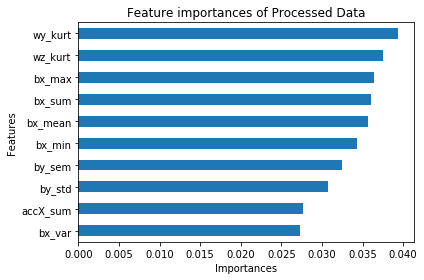

In [45]:
fig, ax = plt.subplots()
imps_top_10.plot.barh(ax=ax)
ax.set_title("Feature importances of Processed Data")
ax.set_xlabel("Importances")
ax.set_ylabel("Features")
ax.tick_params(axis='x', which='major', labelsize=10)
ax.tick_params(axis='y', which='major', labelsize=10)
fig.tight_layout()

In [9]:
train_df.iloc[:,111]

0       3.0
1       3.0
2       3.0
3       3.0
4       3.0
       ... 
2155    3.0
2156    3.0
2157    3.0
2158    3.0
2159    3.0
Name: Activity, Length: 2160, dtype: float64

In [13]:
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(train_df.iloc[:,1:111], train_df.iloc[:,111])
# y_preds_xgb = xgb_cl.predict(test_df.iloc[:,1:111])

XGBoostError: [13:49:40] ../src/data/data.cc:1104: Check failed: valid: Input data contains `inf` or `nan`
Stack trace:
  [bt] (0) /home/ss26/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x1fce19) [0x7f0f8adfce19]
  [bt] (1) /home/ss26/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x221e0d) [0x7f0f8ae21e0d]
  [bt] (2) /home/ss26/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x275b07) [0x7f0f8ae75b07]
  [bt] (3) /home/ss26/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x212895) [0x7f0f8ae12895]
  [bt] (4) /home/ss26/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(XGDMatrixCreateFromDense+0x432) [0x7f0f8ad3aef2]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.7(+0x6ff5) [0x7f101d73aff5]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.7(+0x640a) [0x7f101d73a40a]
  [bt] (7) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(_ctypes_callproc+0x5b6) [0x7f101c7d0306]
  [bt] (8) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x139dc) [0x7f101c7d09dc]

